# Project: SQLite Basic queries with SQLite (CIAFactbook)

<br>

## Questions to address:
- What are the most populated countries
- What is the distribution of population, population growth, birth rate and death rate for all countries in the world?
- What are the countries with the highest population density?

<br>

## Tools:
- SQLite3
- 'Select * from sqlite_master where type="table"'
- basic sql queries: LIMIT, max, order by, 
- subqueries

<br>

### load defaults

In [3]:
import sqlite3
import pandas as pd
import re
import numpy as np
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))

<br>

## Dataset: CIA World Factbook about country demographics in 2015 

### Check which tables are available

In [6]:
conn = sqlite3.connect('./data/original_factbook.db')
query = 'Select * from sqlite_master where type="table"'
df = pd.read_sql_query(query, conn)
display(df)

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,states,states,36,"CREATE TABLE states(id integer primary key, \n..."


In [9]:
query = 'Select * from facts LIMIT 5'
df = pd.read_sql_query(query, conn)
display(df.iloc[:3,:-1])

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286


<br>

## Analysis

<br>

### Q1: What is the largest and smaller population and population growth?

In [10]:
query = '''Select MIN(population) as min, 
                  MAX(population) as max, 
                  MIN(population_growth) as min_growth, 
                  MAX(population_growth) as max_growth from facts'''
pd.read_sql_query(query, conn)

,min,max,min_growth,max_growth
0,0,7256490011,0.0,4.02


- minimum 0 and maximum 7 billion, these don't seem to be countries

<br>

### Q2: What is the entry with population = 0?

In [14]:
query = 'Select * from facts where population=0'
df = pd.read_sql_query(query, conn)
display(df.iloc[:,:-2])

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


<br>

### Q3: Do a subquery to find the entry with population = max(population)

In [15]:
query = 'Select * from facts where population = (Select Max(population) from facts)'
df = pd.read_sql_query(query, conn)
display(df.iloc[:,:-2])

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


- there is an entry for the world, hence the 7 billion

<br>

### Q4: Select all countries with pop>min(pop) and pop<max(pop) and analyse the distribution of population, population growth, birth rate and death rate

Order by population DESC to get the countries with highest population

In [27]:
query = 'Select name, population, population_growth, birth_rate, death_rate from facts where population>0 and population<(select MAX(population) from facts) order by population DESC'
df = pd.read_sql_query(query, conn)
display(df[:5])

,name,population,population_growth,birth_rate,death_rate
0,China,1367485388,0.45,12.49,7.53
1,India,1251695584,1.22,19.55,7.32
2,European Union,513949445,0.25,10.20,10.20
3,United States,321368864,0.78,12.49,8.15
4,Indonesia,255993674,0.92,16.72,6.37


Histograms for the different quantities:

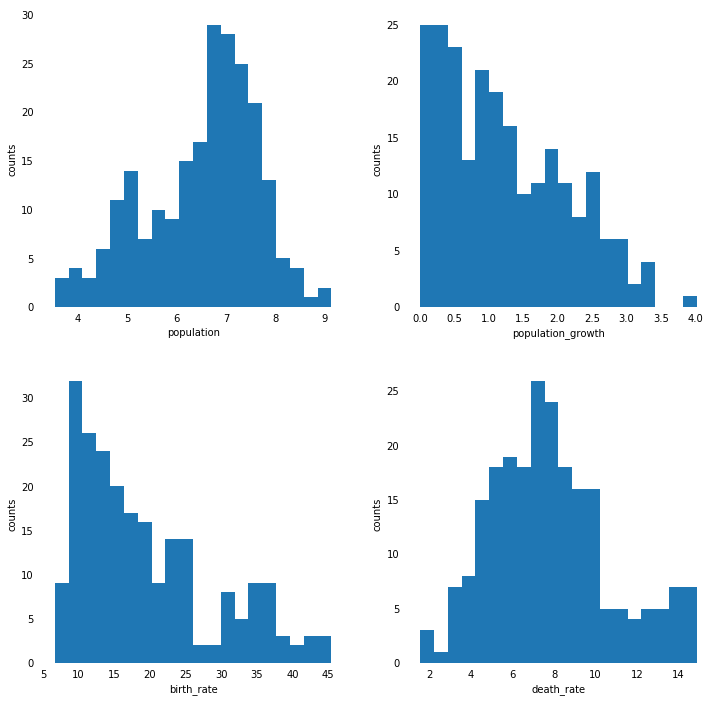

In [19]:
fig = plt.figure(figsize=(12,12))

properties = ['population', 'population_growth', 'birth_rate', 'death_rate']

for idx, xx in enumerate(properties):    
    ax = fig.add_subplot(2,2, idx+1)
    #drop rows with any entry as NaN    
    df.dropna(axis=0, how='any', inplace=True)   
    prop = df[xx]              
    
    if(xx == 'population'): 
        prop = np.log10(prop)
    ax.hist(prop, bins=20)
    
    for key,spine in ax.spines.items():
        spine.set_visible(False)
    ax.tick_params(left='off', bottom='off')      
    ax.set_xlabel(xx)
    ax.set_ylabel('counts')
    
plt.show()

<br>

### Q5: Which countries have the highest population density?

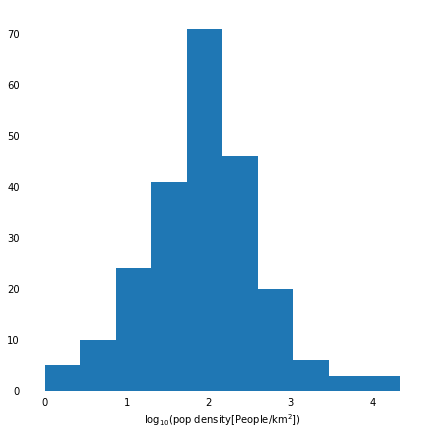

In [21]:
query = 'select name, population/area_land as pop_density from facts order by pop_density DESC'
df = pd.read_sql_query(query, conn)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
df = df.dropna(axis=0, how='any')
df = df[df['pop_density']>0]
ax.hist(np.log10(df['pop_density']))

for key, spine in ax.spines.items():
        spine.set_visible(False)
ax.tick_params(left='off', bottom='off')
ax.set_xlabel('$\log_{10}(\mathrm{pop\;density}[\mathrm{People}/\mathrm{km}^2])$')
plt.show()

In [24]:
print("Countries with the highest population density (N_people/km^2):")
print(df[0:10])

Countries with the highest population density (N_people/km^2):
         name  pop_density
0       Macau      21168.0
1      Monaco      15267.0
2   Singapore       8259.0
3   Hong Kong       6655.0
4  Gaza Strip       5191.0
5   Gibraltar       4876.0
6     Bahrain       1771.0
7    Maldives       1319.0
8       Malta       1310.0
9     Bermuda       1299.0
